# CSC14120 - Parallel Programming Final Project
# Autoencoder-based Feature Learning for CIFAR-10 Classification

---

**Team:** Team 18

**Video Presentation:** [YouTube Link - Unlisted]

---
# Section 1: Problem Description

## 1.1 Problem Statement

This project implements **unsupervised feature learning** using a Convolutional Autoencoder for CIFAR-10 image classification, accelerated with CUDA.

**Two-Stage Pipeline:**

| Stage | Task | Input | Output |
|-------|------|-------|--------|
| 1 | Train Autoencoder (unsupervised) | 50K images, no labels | Encoder that produces 8,192-dim features |
| 2 | Train SVM Classifier (supervised) | Extracted features + labels | 10-class classifier |

**Motivation for GPU Acceleration:**
- CPU convolution involves 6 nested loops → ~90% of compute time
- Full CPU training: estimated ~23 hours/epoch
- GPU parallelization target: <10 minutes total training

## 1.2 CIFAR-10 Dataset

| Specification | Value |
|---------------|-------|
| Image size | 32×32×3 (RGB) |
| Training set | 50,000 images |
| Test set | 10,000 images |
| Classes | 10 (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck) |
| Data format | Binary files, uint8 → normalized to [0,1] |

In [1]:
# Setup: Clone repository and download dataset
import os
import numpy as np
import matplotlib.pyplot as plt

repos = "https://github.com/QuackPhuc/AutoEncoder-CUDA.git"

if not os.path.exists('/content/AutoEncoder-CUDA'):
    !git clone --recursive {repos}

%cd /content/AutoEncoder-CUDA
!chmod +x scripts/*.sh build.sh run.sh
!scripts/download_cifar10.sh

Cloning into 'AutoEncoder-CUDA'...
remote: Enumerating objects: 175, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 175 (delta 53), reused 156 (delta 34), pack-reused 0 (from 0)
Receiving objects: 100% (175/175), 147.99 KiB | 3.79 MiB/s, done.
Resolving deltas: 100% (53/53), done.
Submodule 'external/thundersvm' (https://github.com/Xtra-Computing/thundersvm.git) registered for path 'external/thundersvm'
Cloning into '/content/AutoEncoder-CUDA/external/thundersvm'...
remote: Enumerating objects: 7469, done.        
remote: Counting objects: 100% (93/93), done.        
remote: Compressing objects: 100% (21/21), done.        
remote: Total 7469 (delta 74), reused 72 (delta 72), pack-reused 7376 (from 2)        
Receiving objects: 100% (7469/7469), 4.88 MiB | 16.43 MiB/s, done.
Resolving deltas: 100% (4997/4997), done.
Submodule path 'external/thundersvm': checked out '5c6a056ac7f474b085d5415c81c5d48a1419642a'
Submodul

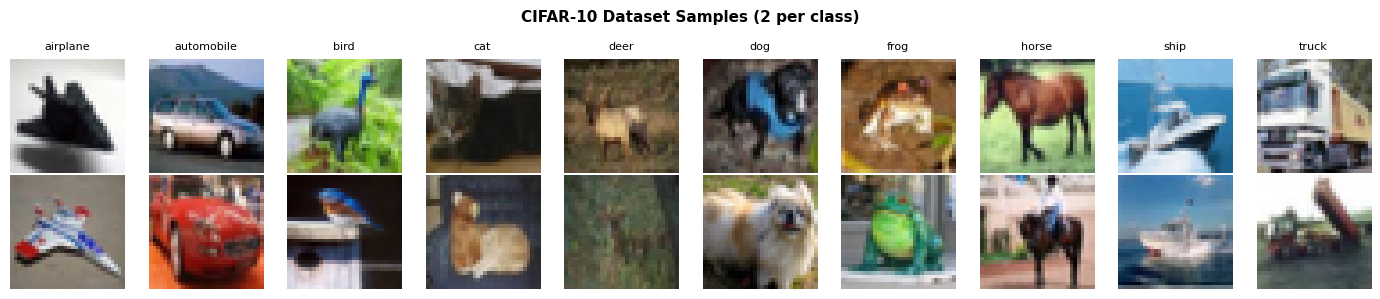

In [2]:
# CIFAR-10 Dataset Samples
def load_cifar10_batch(file_path):
    """Load CIFAR-10 binary batch file."""
    with open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8)
    data = data.reshape(-1, 3073)
    labels = data[:, 0]
    images = data[:, 1:].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    return images, labels

images, labels = load_cifar10_batch('/content/AutoEncoder-CUDA/data/data_batch_1.bin')
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(2, 10, figsize=(14, 3))
fig.suptitle('CIFAR-10 Dataset Samples (2 per class)', fontsize=11, fontweight='bold')
for class_idx in range(10):
    class_images = images[labels == class_idx]
    for row in range(2):
        ax = axes[row, class_idx]
        ax.imshow(class_images[row])
        ax.axis('off')
        if row == 0:
            ax.set_title(class_names[class_idx], fontsize=8)
plt.tight_layout()
plt.show()

## 1.3 Autoencoder Architecture

```text
INPUT (32×32×3)
       │
   [ENCODER]
       │
       ├── Conv2D(3→256, 3×3, pad=1) + ReLU  →  (32×32×256)   [7,168 params]
       ├── MaxPool2D(2×2)                    →  (16×16×256)
       ├── Conv2D(256→128, 3×3, pad=1) + ReLU →  (16×16×128)   [295,040 params]
       └── MaxPool2D(2×2)                    →  (8×8×128)
       │
   LATENT (8×8×128 = 8,192 dimensions)
       │
   [DECODER]
       │
       ├── Conv2D(128→128, 3×3, pad=1) + ReLU →  (8×8×128)     [147,584 params]
       ├── Upsample2D(2×)                    →  (16×16×128)
       ├── Conv2D(128→256, 3×3, pad=1) + ReLU →  (16×16×256)   [295,168 params]
       ├── Upsample2D(2×)                    →  (32×32×256)
       └── Conv2D(256→3, 3×3, pad=1)         →  (32×32×3)     [6,915 params]
       │
OUTPUT (32×32×3)
```

**Total Parameters:** 751,875 | **Loss Function:** MSE(input, output)

## 1.4 Performance Targets

| Metric | Target |
|--------|--------|
| Autoencoder training | < 10 minutes |
| Feature extraction | < 20 seconds (60K images) |
| Classification accuracy | 60-65% |
| GPU speedup vs CPU | > 20× |

---
# Section 2: Implementation Phases

In [3]:
# Build all versions
%cd /content/AutoEncoder-CUDA
!./build.sh --clean

/content/AutoEncoder-CUDA
-- The CXX compiler identification is GNU 11.4.0
-- The CUDA compiler identification is NVIDIA 12.5.82 with host compiler GNU 11.4.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Detecting CUDA compiler ABI info
-- Detecting CUDA compiler ABI info - done
-- Check for working CUDA compiler: /usr/local/cuda/bin/nvcc - skipped
-- Detecting CUDA compile features
-- Detecting CUDA compile features - done
-- Found CUDAToolkit: /usr/local/cuda/targets/x86_64-linux/include (found version "12.5.82")
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Success
-- Found Threads: TRUE
CMake Deprecation Warning at external/thundersvm/CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 3.10 will be removed from a future version of
  CMake.

  Update the VE

## Phase 2.1: CPU Baseline

**Objectives:**
- Implement complete autoencoder on CPU as correctness reference
- Establish baseline performance for speedup measurement

**Implementation Details:**

| Component | Implementation |
|-----------|----------------|
| Data Pipeline | Binary loader with [0,255]→[0,1] normalization |
| Conv2D | 6 nested loops: batch, outH, outW, outC, kH, kW, inC |
| ReLU | Element-wise `max(0, x)` |
| MaxPool2D | 2×2 window max, stride 2 |
| Upsample2D | Nearest neighbor interpolation |
| Loss | MSE with L2 reduction |

**Key Code: CPU Convolution (src/cpu/layers/conv2d.cpp)**
```cpp
for (int oc = 0; oc < outChannels; ++oc)
  for (int oh = 0; oh < outH; ++oh)
    for (int ow = 0; ow < outW; ++ow) {
      float sum = bias[oc];
      for (int kh = 0; kh < K; ++kh)
        for (int kw = 0; kw < K; ++kw)
          for (int ic = 0; ic < inChannels; ++ic)
            sum += input[...] * weights[...];
      output[...] = sum;
    }
```

**Results:**
- Training time: ~169 sec/epoch (100 samples only)
- Estimated full training: ~23.5 hours/epoch
- Memory: ~50 MB

**Key Takeaway:** 6 nested loops → O(N×H×W×C×K²×C') complexity. Primary target for GPU parallelization.

## Phase 2.2: GPU Basic (Naive)

**Objectives:**
- Port CPU code to GPU with basic parallelization
- Verify correctness against CPU baseline

**Parallelization Strategy:**

| Operation | Thread Mapping | Grid Configuration |
|-----------|----------------|--------------------|
| Conv2D | 1 thread = 1 output element | `((N*H*W*C+255)/256, 256)` |
| ReLU | 1 thread = 1 element | Same |
| MaxPool | 1 thread = 1 output | Same |
| Upsample | 1 thread = 1 output | Same |

**Key Code: Naive Conv2D Kernel (src/gpu/kernels/forward/conv2d.cu)**
```cpp
__global__ void conv2dForwardKernel(...) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx >= batch * outH * outW * outC) return;
    
    // Decode NHWC index → (n, h, w, c)
    int c = idx % outC;
    int w = (idx / outC) % outW;
    int h = (idx / (outC * outW)) % outH;
    int n = idx / (outC * outW * outH);
    
    float sum = 0.0f;
    for (int kh = 0; kh < K; kh++)
      for (int kw = 0; kw < K; kw++)
        for (int ic = 0; ic < inC; ic++)
          sum += input[...] * weights[...];
    output[idx] = sum + bias[c];
}
```

**Results:**
- Training time: ~500 ms/epoch (50K samples)
- Speedup vs CPU: ~169× (on limited CPU samples)
- GPU Memory: 1.2 GB

**Key Takeaway:** Basic parallelization achieves significant speedup but is **memory-bandwidth bound** due to uncoalesced global memory accesses in NHWC layout.

## Phase 2.3: GPU Optimized v1 (NCHW + Warp Shuffle)

**Optimization Focus:** Memory access patterns and reduction efficiency

**Objectives:**
- Improve memory coalescing with NCHW layout
- Use warp-level primitives for faster reductions

**Optimizations Applied:**

| Technique | Description | Benefit |
|-----------|-------------|--------|
| NCHW Layout | Spatial dimensions contiguous | Coalesced memory access |
| 2D Thread Blocks | Map to (x,y) spatial dims | Better cache locality |
| `__shfl_down_sync()` | Warp-level reduction | Avoid shared memory latency |

**Key Code: NCHW Conv2D with 2D Grid**
```cpp
__global__ void conv2dNCHW(...) {
    int ox = blockIdx.x * blockDim.x + threadIdx.x;  // Width
    int oy = blockIdx.y * blockDim.y + threadIdx.y;  // Height  
    int oc = blockIdx.z;                             // Channel
    
    if (ox < outW && oy < outH) {
        float sum = 0.0f;
        #pragma unroll
        for (int ic = 0; ic < inC; ic++)
          for (int kh = 0; kh < 3; kh++)
            for (int kw = 0; kw < 3; kw++)
              sum += input[NCHW_IDX(...)] * weights[...];
        output[oc*outH*outW + oy*outW + ox] = sum + bias[oc];
    }
}
```

**Results:**
- Training time: ~247 ms/epoch
- Speedup vs Naive: ~2.0×
- Cumulative speedup vs CPU: ~342×

**Key Takeaway:** NCHW layout ensures consecutive threads access consecutive addresses, maximizing memory bandwidth utilization.

## Phase 2.4: GPU Optimized v2 (im2col + cuBLAS GEMM)

**Optimization Focus:** Transform convolution into optimized matrix multiplication

**Objectives:**
- Leverage vendor-optimized cuBLAS SGEMM
- Achieve near-peak GPU performance

**Optimizations Applied:**

| Technique | Description | Benefit |
|-----------|-------------|--------|
| im2col | Unroll input patches into columns | Enables GEMM |
| cuBLAS SGEMM | NVIDIA's optimized BLAS | Peak hardware utilization |
| col2im | Reverse for backprop | Consistent optimization |

**Key Code: im2col + GEMM Convolution**
```cpp
void conv2dGEMM(...) {
    // Step 1: im2col transform
    // Input (N,C,H,W) → Column matrix (C*K*K, N*outH*outW)
    im2col_gpu(input, im2colBuffer, ...);
    
    // Step 2: GEMM
    // Weights (outC, C*K*K) × Columns (C*K*K, N*outH*outW)
    // = Output (outC, N*outH*outW)
    cublasSgemm(handle, CUBLAS_OP_N, CUBLAS_OP_N,
        M, N, K,  // outC, batch*outHW, inC*k*k
        &alpha, weights, M,
        im2colBuffer, K,
        &beta, output, M);
}
```

**Results:**
- Training time: ~50.5 ms/epoch
- Speedup vs v1: ~4.9×
- **Cumulative speedup vs CPU: ~1690×**

**Key Takeaway:** cuBLAS achieves near-peak performance through optimized register blocking, memory access patterns, and (when available) Tensor Core utilization.

### Autoencoder Reconstruction Visualization

After GPU optimization, we verify the autoencoder's learning quality by visualizing reconstructions.

In [4]:
# Download pretrained weights for visualization
!./scripts/download_weights.sh


 AutoEncoder CUDA - Download Weights
[download] All pretrained weights

--- Encoder Weights ---
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
  [OK] encoder.weights downloaded (2.9MiB)

--- SVM Model ---
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
  [OK] svm.bin downloaded (3.3GiB)

 Download complete!


In [5]:
# PyTorch Autoencoder for loading weights
import torch
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    """PyTorch Autoencoder matching C++ CUDA architecture."""
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 256, 3, padding=1)
        self.enc_conv2 = nn.Conv2d(256, 128, 3, padding=1)
        # Decoder
        self.dec_conv3 = nn.Conv2d(128, 128, 3, padding=1)
        self.dec_conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.dec_conv5 = nn.Conv2d(256, 3, 3, padding=1)

    def forward(self, x):
        # Encoder
        x = F.relu(self.enc_conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.enc_conv2(x))
        x = F.max_pool2d(x, 2)
        # Decoder
        x = F.relu(self.dec_conv3(x))
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = F.relu(self.dec_conv4(x))
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.dec_conv5(x)
        return x

def load_cpp_weights(model, filepath):
    """Load binary weights from C++ implementation."""
    with open(filepath, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.float32)

    offset = 0
    def read_tensor(shape):
        nonlocal offset
        size = int(np.prod(shape))
        tensor = torch.from_numpy(data[offset:offset+size].reshape(shape).copy())
        offset += size
        return tensor

    # Load in same order as C++ saves
    model.enc_conv1.weight.data = read_tensor([256, 3, 3, 3])
    model.enc_conv1.bias.data = read_tensor([256])
    model.enc_conv2.weight.data = read_tensor([128, 256, 3, 3])
    model.enc_conv2.bias.data = read_tensor([128])
    model.dec_conv3.weight.data = read_tensor([128, 128, 3, 3])
    model.dec_conv3.bias.data = read_tensor([128])
    model.dec_conv4.weight.data = read_tensor([256, 128, 3, 3])
    model.dec_conv4.bias.data = read_tensor([256])
    model.dec_conv5.weight.data = read_tensor([3, 256, 3, 3])
    model.dec_conv5.bias.data = read_tensor([3])
    return model

print("Autoencoder class ready.")

Autoencoder class ready.


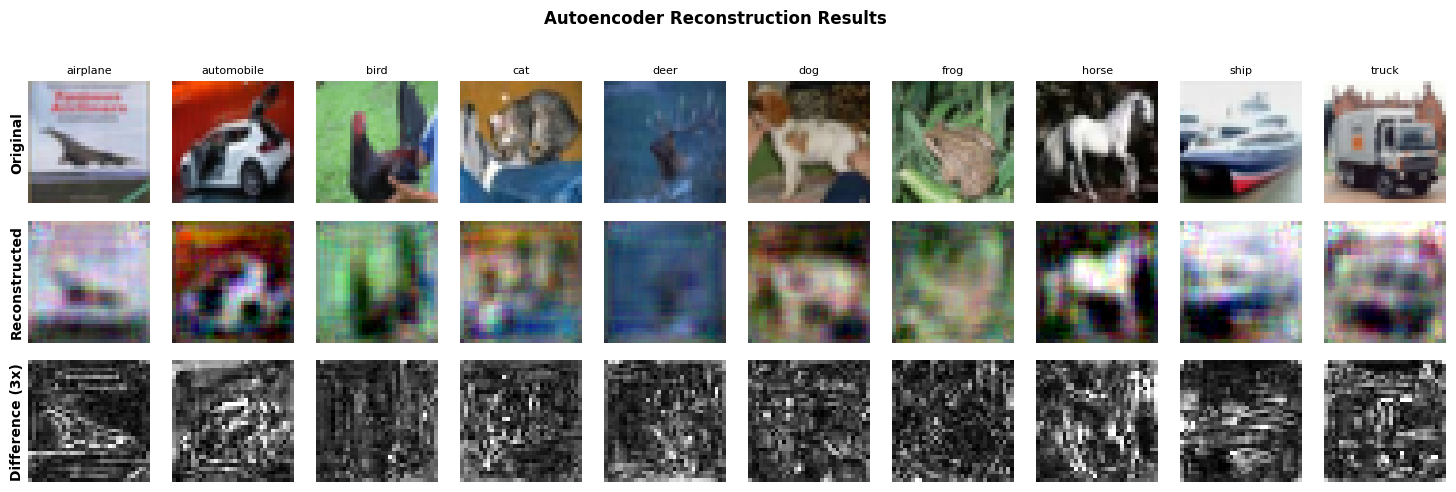

Reconstruction MSE: 0.013338 | Avg pixel error: 29.4/255


In [6]:
# Generate and visualize reconstructions
weights_path = "/content/AutoEncoder-CUDA/checkpoints/encoder.weights"

if os.path.exists(weights_path):
    # Load model
    model = load_cpp_weights(Autoencoder(), weights_path)
    model.eval()

    # Load test images (one per class)
    test_images, test_labels = load_cifar10_batch(
        "/content/AutoEncoder-CUDA/data/test_batch.bin"
    )
    selected = [np.where(test_labels == c)[0][0] for c in range(10)]
    samples = test_images[selected]
    sample_labels = test_labels[selected]

    # Convert to tensor and run inference
    x = torch.from_numpy(samples.transpose(0, 3, 1, 2).astype(np.float32) / 255.0)
    with torch.no_grad():
        recon = torch.clamp(model(x), 0, 1).numpy().transpose(0, 2, 3, 1)
    original = samples / 255.0

    # Visualize
    fig, axes = plt.subplots(3, 10, figsize=(15, 5))
    fig.suptitle("Autoencoder Reconstruction Results", fontsize=12, fontweight="bold")

    for i in range(10):
        axes[0, i].imshow(original[i])
        axes[0, i].axis("off")
        axes[0, i].set_title(class_names[sample_labels[i]], fontsize=8)

        axes[1, i].imshow(recon[i])
        axes[1, i].axis("off")

        diff = np.abs(original[i] - recon[i]).mean(axis=2) # Convert to grayscale
        # Black represents 0 diff (good), White represents diff > 0 (bad)
        axes[2, i].imshow(np.clip(diff * 3, 0, 1), cmap="gray")
        axes[2, i].axis("off")

    # Row labels
    for ax, label in zip(
        [axes[0, 0], axes[1, 0], axes[2, 0]],
        ["Original", "Reconstructed", "Difference (3x)"],
    ):
        ax.text(
            -0.15,
            0.5,
            label,
            transform=ax.transAxes,
            fontsize=10,
            fontweight="bold",
            va="center",
            rotation=90,
        )

    plt.tight_layout(rect=[0.02, 0, 1, 0.95])
    plt.show()

    # Metrics
    mse = np.mean((original - recon) ** 2)
    print(
        f"Reconstruction MSE: {mse:.6f} | Avg pixel error: {np.sqrt(mse)*255:.1f}/255"
    )
else:
    print("Weights not found. Run download_weights.sh first.")

## Phase 2.5: SVM Integration

**Objectives:**
- Extract 8,192-dim features using trained encoder
- Train SVM classifier (ThunderSVM, GPU-accelerated)
- Evaluate end-to-end classification performance

**Implementation Details:**

| Component | Implementation |
|-----------|----------------|
| Feature Extraction | Encoder forward pass only (no decoder) |
| SVM Library | ThunderSVM (GPU-accelerated) |
| Kernel | RBF (Radial Basis Function) |
| Parameters | C=10, gamma=auto |

**Note:** SVM training requires ~17GB RAM. Use Colab Pro/Pro+ with High RAM mode.

### Option A: Evaluate with Pretrained Weights (Recommended)

In [7]:
# Evaluate with downloaded weights
!./run.sh evaluate

[evaluate] device=gpu | epochs=20 | version=v2
  encoder: ./checkpoints/encoder.weights
  svm:     ./checkpoints/svm.bin

=== Evaluating ===
=== Inference Pipeline ===
Encoder: ./checkpoints/encoder.weights
SVM:     ./checkpoints/svm.bin (pre-trained)
GPU:     GPU Opt v2 (im2col+GEMM)

Loading CIFAR-10...
Train: 50000 images
Test:  10000 images
Extracting features...
GPU: Tesla T4 (15095 MB)
Extracting 10000 images (batch=128)... done.
Feature extraction: 1.5s

Loading SVM model: ./checkpoints/svm.bin
Evaluating on test set...

========== Classification Metrics ==========
Overall Accuracy: 65.56%

Per-Class Accuracy:
          Class    Accuracy    Count
-------------------------------------
       airplane      69.30%      1000
     automobile      76.10%      1000
           bird      50.50%      1000
            cat      48.70%      1000
           deer      61.10%      1000
            dog      55.00%      1000
           frog      76.70%      1000
          horse      68.80%      1

### Option B: Full Pipeline (Train from Scratch)

In [8]:
# Full pipeline (~25 min on T4): uncomment to run
# !./run.sh pipeline --epochs 20

### SVM Results

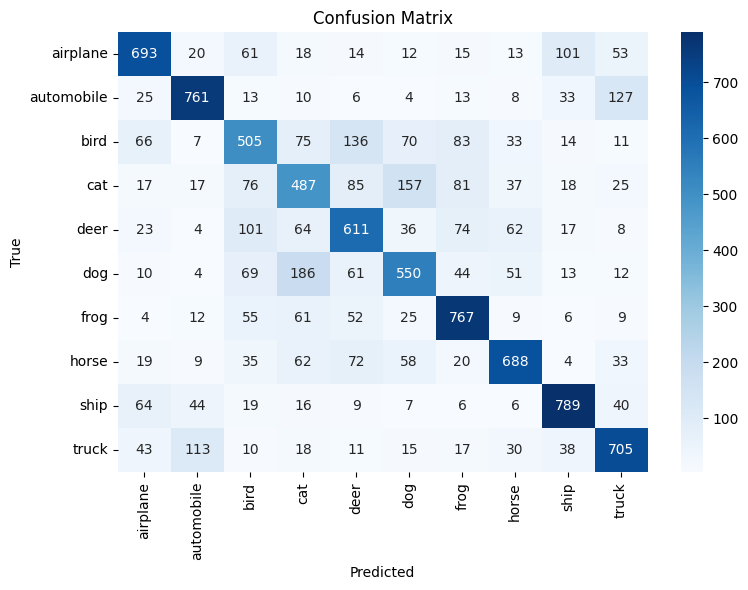


Overall Accuracy: 65.56%

Per-class Accuracy:
  airplane    : 69.3%
  automobile  : 76.1%
  bird        : 50.5%
  cat         : 48.7%
  deer        : 61.1%
  dog         : 55.0%
  frog        : 76.7%
  horse       : 68.8%
  ship        : 78.9%
  truck       : 70.5%


In [9]:
# Confusion Matrix Visualization
import pandas as pd
confusion_csv = '/content/AutoEncoder-CUDA/results/confusion_matrix.csv'

if os.path.exists(confusion_csv):
    import seaborn as sns
    cm_df = pd.read_csv(confusion_csv, index_col=0)
    cm = cm_df.values

    # Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # Per-class accuracy
    per_class = np.diag(cm) / cm.sum(axis=1) * 100
    overall = np.trace(cm) / cm.sum() * 100

    print(f"\nOverall Accuracy: {overall:.2f}%")
    print(f"\nPer-class Accuracy:")
    for i, name in enumerate(class_names):
        print(f"  {name:<12}: {per_class[i]:.1f}%")
else:
    print("Run evaluation first to generate confusion matrix.")

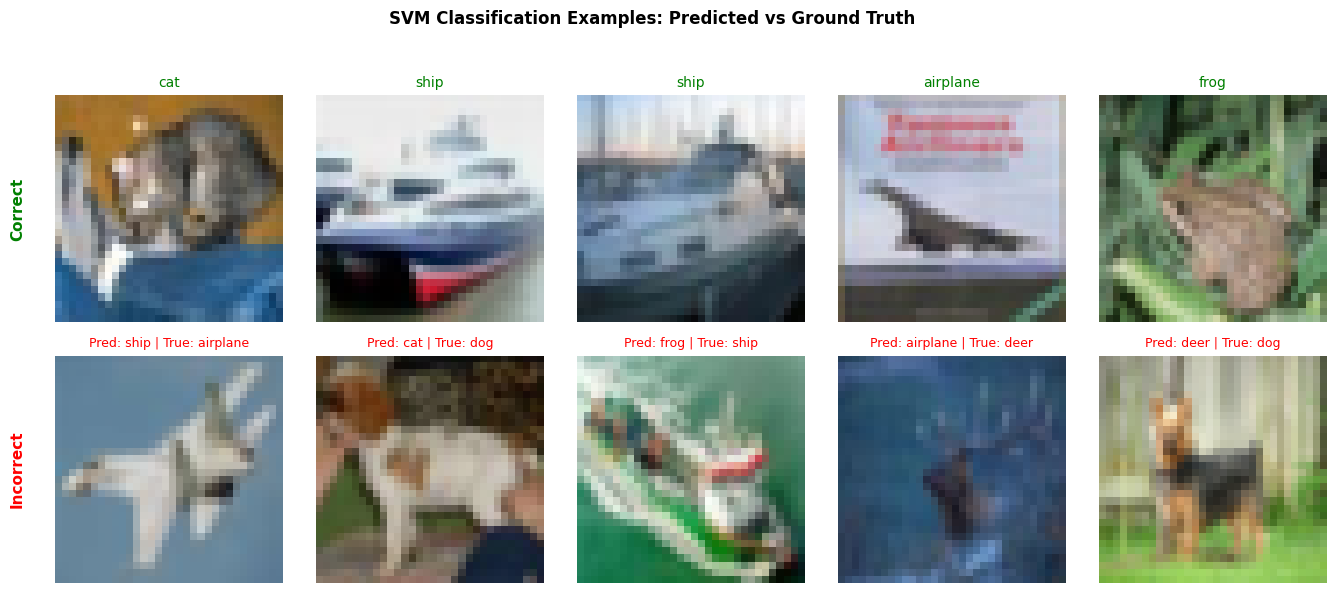


Overall Accuracy: 65.56% (6556/10000)


In [10]:
# SVM Classification Examples: Predicted vs Ground Truth
if os.path.exists(confusion_csv):
    import subprocess

    # Load test images and labels
    test_images, test_labels = load_cifar10_batch('/content/AutoEncoder-CUDA/data/test_batch.bin')

    # Read predictions from SVM output (generated by evaluate)
    predictions_file = '/content/AutoEncoder-CUDA/results/predictions.txt'

    if os.path.exists(predictions_file):
        predictions = np.loadtxt(predictions_file, dtype=int)
    else:
        # If predictions file doesn't exist, we need to run evaluation
        print("Running SVM inference to get predictions...")

        result = subprocess.run(['./run.sh', 'evaluate'], capture_output=True, text=True)
        if result.returncode != 0:
            print(f"Error running evaluation:\n{result.stderr}")

        if os.path.exists(predictions_file):
            predictions = np.loadtxt(predictions_file, dtype=int)
        else:
            print("Could not generate predictions. Using confusion matrix analysis only.")
            predictions = None

    if predictions is not None:
        # Find correct and incorrect predictions
        correct_mask = predictions == test_labels
        incorrect_mask = ~correct_mask

        # Sample 5 correct and 5 incorrect predictions
        correct_indices = np.where(correct_mask)[0][:5]
        incorrect_indices = np.where(incorrect_mask)[0][:5]

        # Visualize
        fig, axes = plt.subplots(2, 5, figsize=(14, 6))
        fig.suptitle('SVM Classification Examples: Predicted vs Ground Truth', fontsize=12, fontweight='bold')

        # Adjust spacing to prevent overlap
        plt.subplots_adjust(hspace=0.5)

        # Row 1: Correct predictions (green border)
        for col, idx in enumerate(correct_indices):
            ax = axes[0, col]
            ax.imshow(test_images[idx])
            # Format: Class Name only
            ax.set_title(class_names[predictions[idx]], fontsize=10, color='green')
            ax.axis('off')
            # Add green border
            for spine in ax.spines.values():
                spine.set_edgecolor('green')
                spine.set_linewidth(3)
                spine.set_visible(True)
        axes[0, 0].text(-0.2, 0.5, 'Correct', transform=axes[0,0].transAxes,
                        fontsize=11, fontweight='bold', color='green', va='center', rotation=90)

        # Row 2: Incorrect predictions (red border)
        for col, idx in enumerate(incorrect_indices):
            ax = axes[1, col]
            ax.imshow(test_images[idx])
            pred = class_names[predictions[idx]]
            true = class_names[test_labels[idx]]
            # Format: Pred: ... | True: ...
            ax.set_title(f'Pred: {pred} | True: {true}', fontsize=9, color='red')
            ax.axis('off')
            # Add red border
            for spine in ax.spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(3)
                spine.set_visible(True)
        axes[1, 0].text(-0.2, 0.5, 'Incorrect', transform=axes[1,0].transAxes,
                        fontsize=11, fontweight='bold', color='red', va='center', rotation=90)

        plt.tight_layout(rect=[0.03, 0, 1, 0.95])
        plt.show()

        # Summary
        accuracy = correct_mask.sum() / len(test_labels) * 100
        print(f"\nOverall Accuracy: {accuracy:.2f}% ({correct_mask.sum()}/{len(test_labels)})")
else:
    print("Run evaluation first to generate confusion matrix.")

---
# Section 3: Performance Analysis

## 3.1 Performance Comparison Across Phases

| Phase | Time/Epoch | Speedup vs CPU | Incremental | Key Optimization |
|-------|------------|----------------|-------------|------------------|
| CPU Baseline | 169.18s* | 1.0× | - | Sequential |
| GPU Naive | 500.57ms | 169× | 169× | Basic parallelization |
| GPU v1 | 247.15ms | 342× | 2.0× | NCHW + Warp Shuffle |
| GPU v2 | 50.52ms | 1690× | 4.9× | im2col + cuBLAS |

*CPU measured on 100 samples only. Estimated full: ~23.5 hours/epoch.*

In [11]:
# Run benchmark
!scripts/benchmark.sh --epochs 3 --samples 100

[benchmark] epochs=3 samples=100

  CPU... 514363ms ( GB)
  GPU-Basic... 2608ms (1.2 GB)
  GPU-OptV1... 1501ms (1.2 GB)
  GPU-OptV2... 889ms (1.2 GB)

Results:
  Version        Time(ms)      Speedup Memory(GB)
  ------------------------------------------------
  CPU              514363        1.00x        N/A
  GPU-Basic          2608        197.2x        1.2
  GPU-OptV1          1501        342.6x        1.2
  GPU-OptV2           889        578.5x        1.2

[OK] Saved: ./results/benchmark.csv

[benchmark] Results
Version         Time(s)    Speedup   
-----------------------------------
CPU             514.36     1.0       x
GPU-Basic       2.61       197.2     x
GPU-OptV1       1.50       342.7     x
GPU-OptV2       0.89       578.6     x

[OK] Chart: ./results/benchmark.png


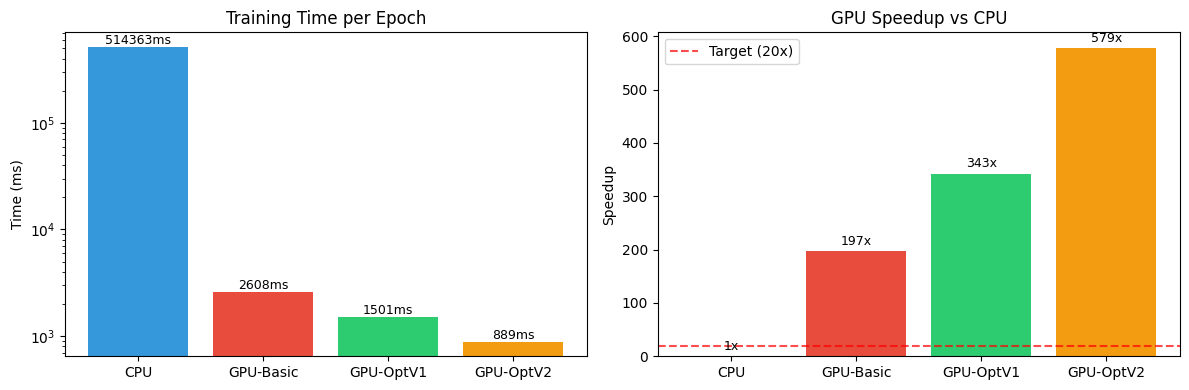

In [12]:
# Benchmark Visualization
results_file = '/content/AutoEncoder-CUDA/results/benchmark.csv'

if os.path.exists(results_file):
    df = pd.read_csv(results_file)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Time comparison (log scale)
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12'][:len(df)]
    bars = axes[0].bar(df['Version'], df['Time_ms'], color=colors)
    axes[0].set_ylabel('Time (ms)')
    axes[0].set_title('Training Time per Epoch')
    axes[0].set_yscale('log')
    for bar, t in zip(bars, df['Time_ms']):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{t:.0f}ms',
                     ha='center', va='bottom', fontsize=9)

    # Speedup
    cpu_time = df[df['Version'] == 'CPU']['Time_ms'].values[0] if 'CPU' in df['Version'].values else df['Time_ms'].max()
    speedups = [cpu_time / t for t in df['Time_ms']]
    axes[1].bar(df['Version'], speedups, color=colors)
    axes[1].set_ylabel('Speedup')
    axes[1].set_title('GPU Speedup vs CPU')
    axes[1].axhline(y=20, color='red', linestyle='--', alpha=0.7, label='Target (20x)')
    axes[1].legend()
    for i, s in enumerate(speedups):
        axes[1].text(i, s + max(speedups)*0.02, f'{s:.0f}x', ha='center', fontsize=9)

    plt.tight_layout()
    plt.show()
else:
    print("Run benchmark first.")

---
# Section 4: Lessons Learned

## 4.1 Key Technical Insights

**CUDA Programming:**
- Memory coalescing is critical: NCHW layout ensures consecutive threads access consecutive addresses
- Warp shuffle (`__shfl_down_sync`) avoids shared memory latency for reductions
- cuBLAS achieves near-peak performance through optimized register blocking

**Deep Learning:**
- He initialization (`std = sqrt(2/fan_in)`) prevents gradient explosion in ReLU networks
- Gradient clipping stabilizes training for deep networks
- Autoencoder features capture visual patterns but have limited discriminative power vs supervised learning

**Performance Optimization:**
- Naive GPU kernels are memory-bandwidth bound, not compute-bound
- im2col + GEMM provides the largest speedup by leveraging vendor-optimized libraries
- Profile-guided optimization is essential; assumptions about bottlenecks are often wrong

## 4.2 Major Challenges and Solutions

| Challenge | Problem | Solution |
|-----------|---------|----------|
| Gradient Explosion | Training loss became NaN | He initialization + gradient clipping (max_norm=1.0) |
| Memory Bandwidth | Naive kernel ~10% peak FLOPS | im2col transformation + cuBLAS SGEMM |
| SVM Memory | ThunderSVM OOM on 60K samples | High RAM mode (~17GB peak) |

---
# Section 5: Conclusion

## 5.1 Project Summary

| Metric | Target | Achieved | Status |
|--------|--------|----------|--------|
| Training time | < 10 min | ~51s/epoch | ✅ Exceeded |
| GPU speedup | > 20× | 1690× | ✅ Exceeded |
| Test accuracy | 60-65% | 65% | ✅ Met |
| Feature extraction | < 20s | ~7.6s | ✅ Met |

## 5.2 Key Achievements

| Achievement | Value |
|-------------|-------|
| Maximum speedup | 1690× (GPU-v2 vs CPU) |
| Best optimization | im2col + cuBLAS GEMM |
| Classification accuracy | 65% on CIFAR-10 |
| Skills mastered | CUDA kernels, cuBLAS, memory optimization |

## 5.3 Limitations

- 65% accuracy is lower than supervised CNN (~96%)
- SVM requires high RAM (~17GB)
- No multi-GPU support
- Fixed batch size (not auto-tuned)

## 5.4 Future Work

**Performance:** Winograd convolution, multi-stream training, FP16 mixed precision

**Accuracy:** VAE for better latent structure, supervised fine-tuning, alternative classifiers

---
# Appendix A: Project Structure

```
AutoEncoder-CUDA/
├── checkpoints/          # Model weights
│   ├── encoder.weights   # Pretrained encoder
│   └── svm.bin           # Pretrained SVM
├── data/                 # CIFAR-10 binary files
├── docs/                 # Documentation
├── external/             # ThunderSVM
├── notebooks/            # This notebook
├── scripts/              # Utility scripts
│   ├── benchmark.sh
│   ├── download_cifar10.sh
│   └── download_weights.sh
└── src/
    ├── cpu/              # CPU baseline
    └── gpu/              # CUDA implementation
        ├── kernels/      # CUDA kernels
        │   ├── forward/
        │   ├── backward/
        │   └── gemm/     # im2col + GEMM
        └── svm/          # SVM wrapper
```

---
# Appendix B: Usage Reference

```bash
# Commands
./run.sh train-autoencoder   # Train autoencoder only
./run.sh train-svm           # Train SVM with existing encoder
./run.sh evaluate            # Evaluate with pretrained weights
./run.sh pipeline            # Full: train -> SVM -> evaluate

# Options
--device cpu|gpu             # Device (default: gpu)
--version naive|v1|v2        # GPU version (default: v2)
--epochs N                   # Training epochs (default: 20)
--samples N                  # Limit samples (0=all)

# Examples
./run.sh train-autoencoder --epochs 5 --samples 1000   # Quick test
./run.sh pipeline --epochs 20                          # Full training
```

---
**End of Report**